In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lightgbm pandas-profiling==2.7.1

In [ ]:
!pip3 install --force-reinstall MarkupSafe==2.0.1

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pandas_profiling as prof
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
import json
from dateutil.relativedelta import relativedelta

%matplotlib inline
pd.set_option('max_columns', 500)


PATH = './drive/MyDrive/Colab Notebooks/Lina/'

In [2]:
def ti():
    print(dt.now().replace(microsecond=0))
       
def get_zaic(df,*args):
    ti()
    if not(isinstance(df,pd.DataFrame) or isinstance(df,pd.Series)):
        print('Не могу вернуть размер для объекта с типом',type(df))
    elif isinstance(df,pd.Series) or isinstance(df,pd.DataFrame) and df.shape[1] == 1:
        print(round(df.memory_usage(deep=True)/1024**2,2),'Mb')
    else:
        print(round(df.memory_usage(deep=True).sum()/1024**2,2),'Mb')
    print(df.shape)

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def calc_metrics(y_train, pred_train, y_test, pred_test, model_type):
    with open(PATH + 'model_logs.json', 'r') as fp:
            logs = json.load(fp)
    logs[model_type] = dict()

    print('TRAIN:')
    r2 = np.round(r2_score(y_train, pred_train), 3)
    print("R^2 : ", r2)
    mae = np.round(mean_absolute_error(y_train, pred_train), 3)
    print("MAE :", mae)
    rmse = np.round(np.sqrt(mean_squared_error(y_train, pred_train)), 3)
    print("RMSE:", rmse)
    mape = np.round(np.sqrt(MAPE(y_train, pred_train)), 3)
    print("MAPE:", mape)
    train_list = [r2, mae, rmse, mape]
    logs[model_type]['TRAIN'] = train_list
    
    print()

    print('TEST:')
    r2 = np.round(r2_score(y_test, pred_test), 3)
    print("R^2 : ", r2)
    mae = np.round(mean_absolute_error(y_test, pred_test), 3)
    print("MAE :", mae)
    rmse = np.round(np.sqrt(mean_squared_error(y_test, pred_test)), 3)
    print("RMSE:", rmse)
    mape = np.round(np.sqrt(MAPE(y_test, pred_test)), 3)
    print("MAPE:", mape)
    test_list = [r2, mae, rmse, mape]
    logs[model_type]['TEST'] = test_list

    with open(PATH + 'model_logs.json', 'w') as fp:
        json.dump(logs, fp)

## Загрузим и посмотрим на данные 

Описание полей в файле price_train.tsv:

* **city_quadkey** - полигон, его координаты можно его узнать из скрипта quadkey.py
* **month** - месяц, за который указаны данные в датасете
* **apartment_ratio** - доля квартир в этом районе в этом месяце со статусом "апартаменты" 
* **offers_in_sites_ratio** - доля офферов в ЖК в этом районе в этом месяце
* **unique_active_buildings_count** - количество домов, в которых есть квартиры в продаже в этом районе в этом месяце
* **AVG_PRICE_SQM** - средняя цена за квадратный метр	в этом районе в этом месяце
* **unique_active_building_series_count** - количество уникальных серий домов, в которых есть квартиры в продаже в этом районе в этом месяце	
* **rooms_offered_*_ratio** - доля квартир указанной в * комнатности от всех квартир в продаже в этом районе в этом месяце 	
* **median_price_sqm** - медианы цены за кв.м. в этом районе в этом месяце	
* **total_area_avg** - средний метраж продаваемой квартиры в этом районе в этом месяце	
* **studio_ratio** - доля объявлений о продаже студии среди всех объявлений в этом районе в этом месяце	
* **offer_count** - число объявлений о продаже квартир в этом районе в этом месяце	

In [ ]:
df_price = pd.read_table(PATH + 'price_train.tsv')
df_price.month = df_price.month.apply(pd.to_datetime)
# df_price['next_month'] = df_price['month'].apply(lambda x: x + 
#                                                  relativedelta(months=1))
df_price.drop(columns=['offers_in_sites_ratio'], inplace=True)  # constss
print(df_price.month.min(), df_price.month.max())
get_zaic(df_price)
df_price.head(3)

2017-01-01 00:00:00 2019-08-01 00:00:00
2022-05-11 12:23:10
17.73 Mb
(166027, 14)


,apartment_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio
0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0
1,0.0,1,22727.273438,2018-03-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0
2,0.0,1,43478.261719,2018-06-01,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0


In [ ]:
# get_zaic(df_price)
# df_price = pd.merge(
#     df_price.drop(columns=['next_month']), 
#     df_price[['avg_price_sqm', 'city_quadkey', 'next_month']].rename(columns={'avg_price_sqm': 'avg_price_sqm_next'}), 
#     left_on=['city_quadkey', 'month'], 
#     right_on=['city_quadkey', 'next_month'],
#     how='left')
# print()
# df_price.dropna(inplace=True)
# get_zaic(df_price)
# df_price.drop(columns=['next_month'], inplace=True)
# df_price.head(3)

Описание полей в датасете про базу домов price_housebase.tsv:

* **city_quadkey** - полигон, его координаты можно его узнать из скрипта quadkey.py
* **building_id** - id дома
* **unified_address** - адрес дома
* **building_series_id** - id серии дома
* **beauty_cnt** - количество салонов красоты в этом районе city_quadkey	
* **shopping_cnt** - количество магазинов в этом районе city_quadkey	 
* **cafe_restaurant_eating_out_cnt** - количество точек общественного питания в этом районе city_quadkey	
* **entertainment_cnt** - количество организаций в сфере развлечений в этом районе city_quadkey
* **sport_cnt** - количество спортивных организаций в этом районе city_quadkey
* **chain_cnt** - количество сетевых организаций в этом районе city_quadkey
* **groceries_and_everyday_items_cnt** - количество продуктовых магазинов в этом районе city_quadkey	
* **art_cnt** - количество организаций в сфере искусства (музеи, галереи и т.п.) в этом районе city_quadkey
* **healthcare_cnt** - количество организаций в сфере здравоохранения в этом районе city_quadkey	
* **flats_count** - количество квартир в доме	
* **laundry_and_repair_services_cnt** - количество прачечных и ремонтных мастерских в этом районе city_quadkey	
* **latitude, longitude** - координаты дома
* **expect_demolition** - дом входит в программу реновации и ожидает сноса
* **ceiling_height** - высота потолков в доме	
* **has_elevator** - наличие лифта в доме	
* **build_year** - год постройки дома

In [ ]:
df_house = pd.read_table(PATH + 'price_housebase.tsv')
get_zaic(df_house)
df_house.expect_demolition = df_house.expect_demolition.apply(int)
df_house.has_elevator = df_house.has_elevator.apply(int)
df_house.head(3)

2022-05-11 12:23:10
45.33 Mb
(112203, 23)


,beauty_cnt,building_id,building_series_id,shopping_cnt,flats_count,latitude,building_type,cafe_restaurant_eating_out_cnt,unified_address,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,site_id,healthcare_cnt,expect_demolition,longitude,ceiling_height,has_elevator,laundry_and_repair_services_cnt,build_year,city_quadkey
0,36.0,3031030817531317628,0,45.0,0,55.705219,BRICK,24.0,"Россия, Москва, 1-й Автозаводский проезд, 3",18.0,13.0,127.0,32.0,7.0,0,16.0,0,37.656994,0.0,1,38.0,1937,120310101302011
1,36.0,3031030817531317630,0,45.0,0,55.704845,BRICK,24.0,"Россия, Москва, 1-й Автозаводский проезд, 5",18.0,13.0,127.0,32.0,7.0,0,16.0,0,37.657295,0.0,0,38.0,1962,120310101302011
2,36.0,1764947998512909470,0,45.0,0,55.704697,UNKNOWN,24.0,"Россия, Москва, 1-й Автозаводский проезд, 7/1",18.0,13.0,127.0,32.0,7.0,0,16.0,0,37.658203,0.0,0,38.0,0,120310101302011


In [ ]:
display(df_house.building_type.value_counts(normalize=True))
df_house.building_type = df_house.building_type.apply(lambda x: 'ANOTHER' if x in 
                                                      ['MONOLIT_BRICK', 
                                                       'WOOD', 
                                                       'METAL', 
                                                       'FERROCONCRETE'] else x)
df_house = pd.get_dummies(df_house, columns=['building_type'])
df_house.head(3)

BRICK            0.358359
PANEL            0.314751
UNKNOWN          0.200119
MONOLIT          0.081923
BLOCK            0.034206
MONOLIT_BRICK    0.008021
WOOD             0.002594
METAL            0.000018
FERROCONCRETE    0.000009
Name: building_type, dtype: float64

,beauty_cnt,building_id,building_series_id,shopping_cnt,flats_count,latitude,cafe_restaurant_eating_out_cnt,unified_address,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,site_id,healthcare_cnt,expect_demolition,longitude,ceiling_height,has_elevator,laundry_and_repair_services_cnt,build_year,city_quadkey,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN
0,36.0,3031030817531317628,0,45.0,0,55.705219,24.0,"Россия, Москва, 1-й Автозаводский проезд, 3",18.0,13.0,127.0,32.0,7.0,0,16.0,0,37.656994,0.0,1,38.0,1937,120310101302011,0,0,1,0,0,0
1,36.0,3031030817531317630,0,45.0,0,55.704845,24.0,"Россия, Москва, 1-й Автозаводский проезд, 5",18.0,13.0,127.0,32.0,7.0,0,16.0,0,37.657295,0.0,0,38.0,1962,120310101302011,0,0,1,0,0,0
2,36.0,1764947998512909470,0,45.0,0,55.704697,24.0,"Россия, Москва, 1-й Автозаводский проезд, 7/1",18.0,13.0,127.0,32.0,7.0,0,16.0,0,37.658203,0.0,0,38.0,0,120310101302011,0,0,0,0,0,1


In [ ]:
useful_cols = [
    'beauty_cnt',
    'shopping_cnt',
    'flats_count',
    'cafe_restaurant_eating_out_cnt',
    'entertainment_cnt',
    'sport_cnt',
    'chain_cnt',
    'groceries_and_everyday_items_cnt',
    'art_cnt',
    'healthcare_cnt',
    'expect_demolition',
    'ceiling_height',
    'laundry_and_repair_services_cnt',
    'building_type_ANOTHER',
    'building_type_BLOCK',
    'building_type_BRICK',
    'building_type_MONOLIT',
    'building_type_PANEL',
    'building_type_UNKNOWN'
]
grouped_housebase = df_house[useful_cols + 
                             ['city_quadkey']].groupby("city_quadkey")

## Добавим информацию о домах

In [ ]:
get_zaic(df_price)

df_price = df_price.merge(grouped_housebase.mean(), how="left", 
                          left_on="city_quadkey", 
                          suffixes=[None,"_bmean"], right_index=True)
df_price = df_price.merge(grouped_housebase.max(),  
                          how="left", left_on="city_quadkey", 
                          suffixes=[None,"_bmax"], right_index=True)
df_price = df_price.merge(grouped_housebase.min(),  
                          how="left", left_on="city_quadkey", 
                          suffixes=[None,"_bmin"], right_index=True)
print()
get_zaic(df_price)
df_price.head(3)

2022-05-11 12:23:11
17.73 Mb
(166027, 14)

2022-05-11 12:23:11
76.63 Mb
(166027, 71)


,apartment_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio,beauty_cnt,shopping_cnt,flats_count,cafe_restaurant_eating_out_cnt,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,healthcare_cnt,expect_demolition,ceiling_height,laundry_and_repair_services_cnt,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN,beauty_cnt_bmax,shopping_cnt_bmax,flats_count_bmax,cafe_restaurant_eating_out_cnt_bmax,entertainment_cnt_bmax,sport_cnt_bmax,chain_cnt_bmax,groceries_and_everyday_items_cnt_bmax,art_cnt_bmax,healthcare_cnt_bmax,expect_demolition_bmax,ceiling_height_bmax,laundry_and_repair_services_cnt_bmax,building_type_ANOTHER_bmax,building_type_BLOCK_bmax,building_type_BRICK_bmax,building_type_MONOLIT_bmax,building_type_PANEL_bmax,building_type_UNKNOWN_bmax,beauty_cnt_bmin,shopping_cnt_bmin,flats_count_bmin,cafe_restaurant_eating_out_cnt_bmin,entertainment_cnt_bmin,sport_cnt_bmin,chain_cnt_bmin,groceries_and_everyday_items_cnt_bmin,art_cnt_bmin,healthcare_cnt_bmin,expect_demolition_bmin,ceiling_height_bmin,laundry_and_repair_services_cnt_bmin,building_type_ANOTHER_bmin,building_type_BLOCK_bmin,building_type_BRICK_bmin,building_type_MONOLIT_bmin,building_type_PANEL_bmin,building_type_UNKNOWN_bmin
0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0
1,0.0,1,22727.273438,2018-03-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0
2,0.0,1,43478.261719,2018-06-01,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0


## Фичи из даты + праздники

In [ ]:
df_price['month_num'] = df_price['month'].apply(lambda x: x.month)
df_price['quarter'] = df_price['month'].apply(lambda x: x.quarter)
df_price.head(3)

,apartment_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio,beauty_cnt,shopping_cnt,flats_count,cafe_restaurant_eating_out_cnt,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,healthcare_cnt,expect_demolition,ceiling_height,laundry_and_repair_services_cnt,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN,beauty_cnt_bmax,shopping_cnt_bmax,flats_count_bmax,cafe_restaurant_eating_out_cnt_bmax,entertainment_cnt_bmax,sport_cnt_bmax,chain_cnt_bmax,groceries_and_everyday_items_cnt_bmax,art_cnt_bmax,healthcare_cnt_bmax,expect_demolition_bmax,ceiling_height_bmax,laundry_and_repair_services_cnt_bmax,building_type_ANOTHER_bmax,building_type_BLOCK_bmax,building_type_BRICK_bmax,building_type_MONOLIT_bmax,building_type_PANEL_bmax,building_type_UNKNOWN_bmax,beauty_cnt_bmin,shopping_cnt_bmin,flats_count_bmin,cafe_restaurant_eating_out_cnt_bmin,entertainment_cnt_bmin,sport_cnt_bmin,chain_cnt_bmin,groceries_and_everyday_items_cnt_bmin,art_cnt_bmin,healthcare_cnt_bmin,expect_demolition_bmin,ceiling_height_bmin,laundry_and_repair_services_cnt_bmin,building_type_ANOTHER_bmin,building_type_BLOCK_bmin,building_type_BRICK_bmin,building_type_MONOLIT_bmin,building_type_PANEL_bmin,building_type_UNKNOWN_bmin,month_num,quarter
0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,2,1
1,0.0,1,22727.273438,2018-03-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,3,1
2,0.0,1,43478.261719,2018-06-01,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,6,2


In [ ]:
def get_days_cnt(x, dates_list):
    cnt = 0
    for elem in dates_list:
        if x.month == elem.month and x.year == elem.year:
            cnt += 1
    return cnt


preholidays = list()
holidays = list()

for year in list(range(2017, 2019)):
    with open(PATH + './consultant' +str(year) + '.json') as f:
        calend = json.load(f)
        for elem in calend['preholidays']:
            preholidays.append(pd.to_datetime(elem))
        for elem in calend['holidays']:
            holidays.append(pd.to_datetime(elem))
        if 'nowork' in calend:
            for elem in calend['nowork']:
                holidays.append(pd.to_datetime(elem))

df_price['prehol_cnt'] = df_price['month'].apply(lambda x: get_days_cnt(x, preholidays))
df_price['hol_cnt'] = df_price['month'].apply(lambda x: get_days_cnt(x, holidays))
df_price.head(3)

,apartment_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio,beauty_cnt,shopping_cnt,flats_count,cafe_restaurant_eating_out_cnt,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,healthcare_cnt,expect_demolition,ceiling_height,laundry_and_repair_services_cnt,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN,beauty_cnt_bmax,shopping_cnt_bmax,flats_count_bmax,cafe_restaurant_eating_out_cnt_bmax,entertainment_cnt_bmax,sport_cnt_bmax,chain_cnt_bmax,groceries_and_everyday_items_cnt_bmax,art_cnt_bmax,healthcare_cnt_bmax,expect_demolition_bmax,ceiling_height_bmax,laundry_and_repair_services_cnt_bmax,building_type_ANOTHER_bmax,building_type_BLOCK_bmax,building_type_BRICK_bmax,building_type_MONOLIT_bmax,building_type_PANEL_bmax,building_type_UNKNOWN_bmax,beauty_cnt_bmin,shopping_cnt_bmin,flats_count_bmin,cafe_restaurant_eating_out_cnt_bmin,entertainment_cnt_bmin,sport_cnt_bmin,chain_cnt_bmin,groceries_and_everyday_items_cnt_bmin,art_cnt_bmin,healthcare_cnt_bmin,expect_demolition_bmin,ceiling_height_bmin,laundry_and_repair_services_cnt_bmin,building_type_ANOTHER_bmin,building_type_BLOCK_bmin,building_type_BRICK_bmin,building_type_MONOLIT_bmin,building_type_PANEL_bmin,building_type_UNKNOWN_bmin,month_num,quarter,prehol_cnt,hol_cnt
0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,2,1,1,9
1,0.0,1,22727.273438,2018-03-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,3,1,1,11
2,0.0,1,43478.261719,2018-06-01,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,6,2,1,10


## Лаги по таргету и сильной фиче

In [ ]:
df_price['prev_month'] = df_price['month'].apply(lambda x: x - 
                                                 relativedelta(months=1))

In [ ]:
get_zaic(df_price)
df_price = pd.merge(
    df_price.drop(columns=['prev_month']), 
    df_price[['avg_price_sqm', 
              'city_quadkey', 
              'prev_month', 
              'median_price_sqm']].rename(columns={'avg_price_sqm': 
                                                   'avg_price_sqm_prev', 
                                                   'median_price_sqm': 
                                                   'median_price_sqm_prev'}), 
    left_on=['city_quadkey', 'month'], 
    right_on=['city_quadkey', 'prev_month'],
    how='left')
print()
get_zaic(df_price)
df_price.drop(columns=['prev_month'], inplace=True)
df_price.head(3)

2022-05-11 12:23:24
82.97 Mb
(166027, 76)

2022-05-11 12:23:25
86.77 Mb
(166027, 78)


,apartment_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio,beauty_cnt,shopping_cnt,flats_count,cafe_restaurant_eating_out_cnt,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,healthcare_cnt,expect_demolition,ceiling_height,laundry_and_repair_services_cnt,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN,beauty_cnt_bmax,shopping_cnt_bmax,flats_count_bmax,cafe_restaurant_eating_out_cnt_bmax,entertainment_cnt_bmax,sport_cnt_bmax,chain_cnt_bmax,groceries_and_everyday_items_cnt_bmax,art_cnt_bmax,healthcare_cnt_bmax,expect_demolition_bmax,ceiling_height_bmax,laundry_and_repair_services_cnt_bmax,building_type_ANOTHER_bmax,building_type_BLOCK_bmax,building_type_BRICK_bmax,building_type_MONOLIT_bmax,building_type_PANEL_bmax,building_type_UNKNOWN_bmax,beauty_cnt_bmin,shopping_cnt_bmin,flats_count_bmin,cafe_restaurant_eating_out_cnt_bmin,entertainment_cnt_bmin,sport_cnt_bmin,chain_cnt_bmin,groceries_and_everyday_items_cnt_bmin,art_cnt_bmin,healthcare_cnt_bmin,expect_demolition_bmin,ceiling_height_bmin,laundry_and_repair_services_cnt_bmin,building_type_ANOTHER_bmin,building_type_BLOCK_bmin,building_type_BRICK_bmin,building_type_MONOLIT_bmin,building_type_PANEL_bmin,building_type_UNKNOWN_bmin,month_num,quarter,prehol_cnt,hol_cnt,avg_price_sqm_prev,median_price_sqm_prev
0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,2,1,1,9,22727.273438,22727.273438
1,0.0,1,22727.273438,2018-03-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,3,1,1,11,NaN,NaN
2,0.0,1,43478.261719,2018-06-01,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,6,2,1,10,43478.261719,43478.261719


## Посмотрим на данные
Можно графиками в питоне с использованием базовых библиотек или более продвинутых. А можно в BI системах (https://datalens.yandex.ru/8ricxji0bd9s0-lina)

In [ ]:
get_zaic(df_price)
df_price.to_csv(PATH + 'df_price.csv')
df_price.head(3)

2022-05-11 12:23:40
85.5 Mb
(166027, 77)


,apartment_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio,beauty_cnt,shopping_cnt,flats_count,cafe_restaurant_eating_out_cnt,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,healthcare_cnt,expect_demolition,ceiling_height,laundry_and_repair_services_cnt,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN,beauty_cnt_bmax,shopping_cnt_bmax,flats_count_bmax,cafe_restaurant_eating_out_cnt_bmax,entertainment_cnt_bmax,sport_cnt_bmax,chain_cnt_bmax,groceries_and_everyday_items_cnt_bmax,art_cnt_bmax,healthcare_cnt_bmax,expect_demolition_bmax,ceiling_height_bmax,laundry_and_repair_services_cnt_bmax,building_type_ANOTHER_bmax,building_type_BLOCK_bmax,building_type_BRICK_bmax,building_type_MONOLIT_bmax,building_type_PANEL_bmax,building_type_UNKNOWN_bmax,beauty_cnt_bmin,shopping_cnt_bmin,flats_count_bmin,cafe_restaurant_eating_out_cnt_bmin,entertainment_cnt_bmin,sport_cnt_bmin,chain_cnt_bmin,groceries_and_everyday_items_cnt_bmin,art_cnt_bmin,healthcare_cnt_bmin,expect_demolition_bmin,ceiling_height_bmin,laundry_and_repair_services_cnt_bmin,building_type_ANOTHER_bmin,building_type_BLOCK_bmin,building_type_BRICK_bmin,building_type_MONOLIT_bmin,building_type_PANEL_bmin,building_type_UNKNOWN_bmin,month_num,quarter,prehol_cnt,hol_cnt,avg_price_sqm_prev,median_price_sqm_prev
0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,2,1,1,9,22727.273438,22727.273438
1,0.0,1,22727.273438,2018-03-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,3,1,1,11,NaN,NaN
2,0.0,1,43478.261719,2018-06-01,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,6,2,1,10,43478.261719,43478.261719


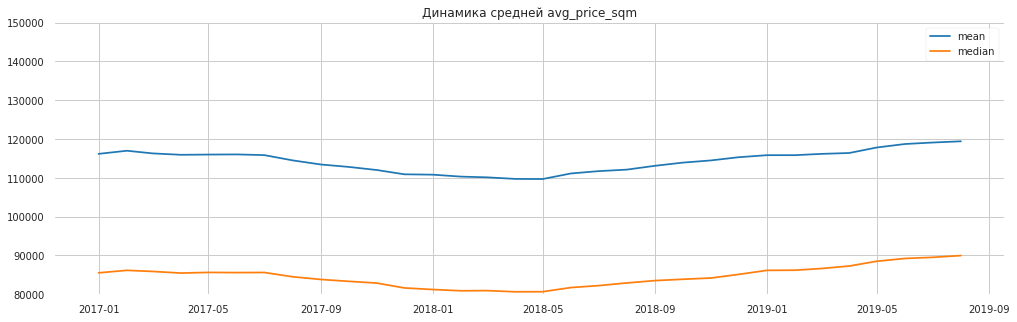

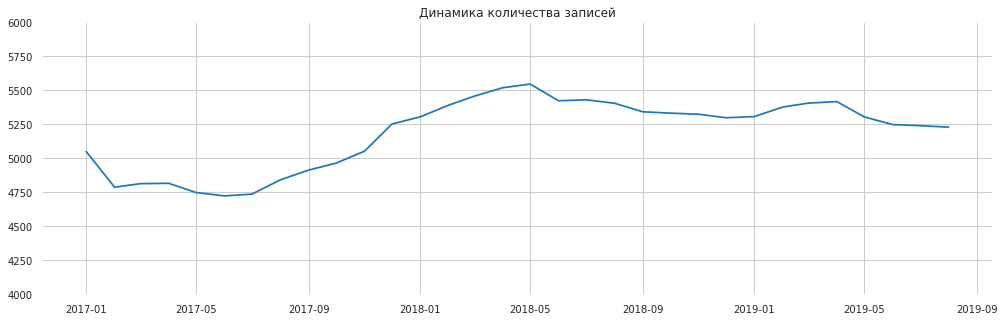

In [ ]:
df_gr = df_price.groupby('month').agg({'avg_price_sqm': 
                                       ['mean', 'count', 'median']}).reset_index()
df_gr.columns=df_gr.columns.droplevel()
df_gr.to_csv(PATH + 'df_gr_avg_price_sqm.csv')

fig = plt.figure(figsize=(17, 5))
plt.plot(df_gr[''], df_gr['mean'])
plt.plot(df_gr[''], df_gr['median'])
plt.title('Динамика средней avg_price_sqm')
plt.ylim([80000, 150000])
plt.grid(True)
plt.legend(['mean', 'median'])
plt.show()
print()
fig = plt.figure(figsize=(17, 5))
plt.plot(df_gr[''], df_gr['count'])
plt.title('Динамика количества записей')
plt.ylim([4000, 6000])
plt.grid(True)
plt.show()

In [ ]:
ANOM_BORDER = df_price['avg_price_sqm'].quantile(0.95)

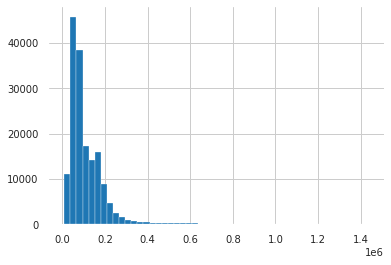

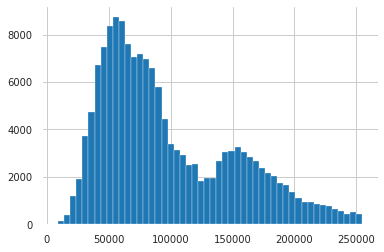

In [ ]:
df_price['avg_price_sqm'].hist(bins=50)
plt.show()
print()
df_price[df_price.avg_price_sqm <= ANOM_BORDER]['avg_price_sqm'].hist(bins=50)
plt.show()

In [ ]:
# В колабе перестало работать, можно запустить на локальном ПК
# prof.ProfileReport(df_price)

## Разбивка на train / test 
Запускаем по походу постепенного добавления фичей, логируя метрики в файле.

Каждая итерация состоит из 2х частей - меняем SPLIT_TIPE и DESCRIBE

In [ ]:
target = 'avg_price_sqm'
SPLIT_TIPE = 'OOT'
DESCRIBE = 'Baseline_' + 'housebase_' + 'TimeFeat_' + 'Lags_'
# target = 'avg_price_sqm_next'
model_cols = [x for x in df_price.columns if x not in [target, 'month']]

if SPLIT_TIPE == 'OOS':
    df_model = df_price[model_cols + [target]].copy()
else:
    df_model = df_price[model_cols + [target] + ['month']].copy()

get_zaic(df_model)
df_model.head(3)

2022-05-11 12:33:21
85.5 Mb
(166027, 77)


,apartment_ratio,unique_active_buildings_count,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio,beauty_cnt,shopping_cnt,flats_count,cafe_restaurant_eating_out_cnt,entertainment_cnt,sport_cnt,chain_cnt,groceries_and_everyday_items_cnt,art_cnt,healthcare_cnt,expect_demolition,ceiling_height,laundry_and_repair_services_cnt,building_type_ANOTHER,building_type_BLOCK,building_type_BRICK,building_type_MONOLIT,building_type_PANEL,building_type_UNKNOWN,beauty_cnt_bmax,shopping_cnt_bmax,flats_count_bmax,cafe_restaurant_eating_out_cnt_bmax,entertainment_cnt_bmax,sport_cnt_bmax,chain_cnt_bmax,groceries_and_everyday_items_cnt_bmax,art_cnt_bmax,healthcare_cnt_bmax,expect_demolition_bmax,ceiling_height_bmax,laundry_and_repair_services_cnt_bmax,building_type_ANOTHER_bmax,building_type_BLOCK_bmax,building_type_BRICK_bmax,building_type_MONOLIT_bmax,building_type_PANEL_bmax,building_type_UNKNOWN_bmax,beauty_cnt_bmin,shopping_cnt_bmin,flats_count_bmin,cafe_restaurant_eating_out_cnt_bmin,entertainment_cnt_bmin,sport_cnt_bmin,chain_cnt_bmin,groceries_and_everyday_items_cnt_bmin,art_cnt_bmin,healthcare_cnt_bmin,expect_demolition_bmin,ceiling_height_bmin,laundry_and_repair_services_cnt_bmin,building_type_ANOTHER_bmin,building_type_BLOCK_bmin,building_type_BRICK_bmin,building_type_MONOLIT_bmin,building_type_PANEL_bmin,building_type_UNKNOWN_bmin,month_num,quarter,prehol_cnt,hol_cnt,avg_price_sqm_prev,median_price_sqm_prev,avg_price_sqm,month
0,0.0,1,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,2,1,1,9,22727.273438,22727.273438,22727.273438,2018-02-01
1,0.0,1,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,0,0,0,0,1,0,3,1,1,11,NaN,NaN,22727.273438,2018-03-01
2,0.0,1,1,0.0,120132230332230,43478.261719,0.0,1.0,34.5,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0,0.0,0.0,0,0,0,0,1,0,6,2,1,10,43478.261719,43478.261719,43478.261719,2018-06-01


In [ ]:
TEST_BORDER = 0.25
OOT_BORDER = pd.to_datetime('2019-01-01')
seed_val = 7575

if SPLIT_TIPE == 'OOS':
    print('OOS MODE')
    X_train, X_test, y_train, y_test = train_test_split(
        df_model[model_cols], df_model[target], 
        test_size=TEST_BORDER, random_state=seed_val)
else:
    print('OOT MODE')
    # X_train = df_model[(df_model.month < OOT_BORDER) & 
    #                    (df_model.avg_price_sqm <= ANOM_BORDER)][model_cols]
    # y_train = df_model[(df_model.month < OOT_BORDER) & 
    #                    (df_model.avg_price_sqm <= ANOM_BORDER)][target]
    X_train = df_model[(df_model.month < OOT_BORDER)][model_cols]
    y_train = df_model[(df_model.month < OOT_BORDER)][target]
    X_test = df_model[(df_model.month >= OOT_BORDER)][model_cols]
    y_test = df_model[(df_model.month >= OOT_BORDER)][target]

OOT MODE


## Baseline

In [ ]:
model = lgb.LGBMRegressor(
    objective = 'regression',  
    max_depth = 5,
)
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

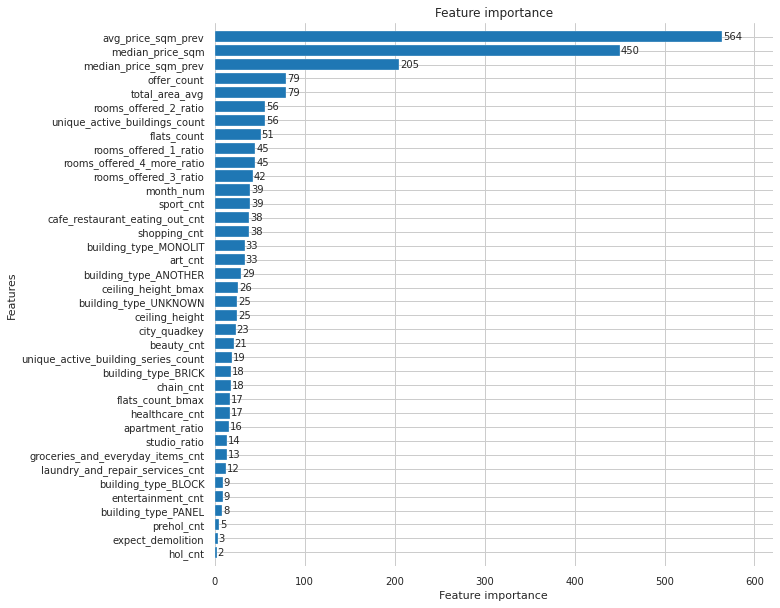

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
ax.set_xlabel('Значимость фактора')
ax.set_ylabel('Имя фактора')
ax.set_title('')
_ = lgb.plot_importance(model, height=0.8, ax=ax)

In [ ]:
calc_metrics(y_train, pred_train, y_test, pred_test, DESCRIBE + SPLIT_TIPE)

TRAIN:
R^2 :  0.996
MAE : 1958.315
RMSE: 5938.24
MAPE: 1.307

TEST:
R^2 :  0.99
MAE : 2782.058
RMSE: 10161.256
MAPE: 1.462


## Uplifts
Покажем динамику улучшения метрик по мере добавления источников

In [3]:
with open(PATH + 'model_logs.json', 'r') as fp:
    logs = json.load(fp)

In [6]:
keys = ['Baseline_', 'Baseline_housebase_', 'Baseline_housebase_TimeFeat_', 
        'Baseline_housebase_TimeFeat_Lags_', 
        'Baseline_housebase_TimeFeat_Lags__TUNED',
        'AN_Baseline_housebase_TimeFeat_']
up_split_type = 'OOT'
up_train_test = 'TEST'
logs

{'AN_Baseline_housebase_TimeFeat_OOT': {'TEST': [0.652,
   11310.756,
   59894.016,
   1.988],
  'TRAIN': [0.996, 1944.264, 3357.127, 1.428]},
 'Baseline_OOS': {'TEST': [0.991, 3371.58, 9739.819, 1.563],
  'TRAIN': [0.993, 3206.056, 8571.37, 1.55]},
 'Baseline_OOT': {'TEST': [0.989, 3896.985, 10811.923, 1.662],
  'TRAIN': [0.992, 3138.233, 8651.772, 1.539]},
 'Baseline_housebase_OOS': {'TEST': [0.994, 3010.925, 7937.497, 1.538],
  'TRAIN': [0.995, 2897.819, 7148.052, 1.526]},
 'Baseline_housebase_OOT': {'TEST': [0.993, 3498.833, 8322.351, 1.63],
  'TRAIN': [0.995, 2793.405, 7243.526, 1.507]},
 'Baseline_housebase_TimeFeat_Lags_OOS': {'TEST': [0.995,
   2182.733,
   7180.118,
   1.346],
  'TRAIN': [0.997, 2062.636, 5741.502, 1.338]},
 'Baseline_housebase_TimeFeat_Lags_OOT': {'TEST': [0.99,
   2782.058,
   10161.256,
   1.462],
  'TRAIN': [0.996, 1958.315, 5938.24, 1.307]},
 'Baseline_housebase_TimeFeat_Lags__TUNEDOOS': {'TEST': [0.996,
   1992.256,
   6740.687,
   1.305],
  'TRAIN': [0.

In [7]:
df_dict = {}
for elem in keys:
    key = elem + up_split_type
    try:
        df_dict[elem] = logs[key][up_train_test]
    except Exception:
        pass

pd.DataFrame(df_dict)

,Baseline_,Baseline_housebase_,Baseline_housebase_TimeFeat_,Baseline_housebase_TimeFeat_Lags_,Baseline_housebase_TimeFeat_Lags__TUNED,AN_Baseline_housebase_TimeFeat_
0,0.989,0.993,0.993,0.990,0.986,0.652
1,3896.985,3498.833,3530.585,2782.058,3446.470,11310.756
2,10811.923,8322.351,8452.243,10161.256,12175.636,59894.016
3,1.662,1.630,1.634,1.462,1.632,1.988


## Test another models

In [ ]:
# TO DO

## Tune
Запускаем только для улучшения финальной итерации

In [ ]:
grid2 = {'n_estimators':[64, 100, 128, 256],
         'max_depth': [3, 5, 7]}
lgbc = lgb.LGBMRegressor(
    n_jobs=16, 
    random_state = seed_val,
    importance_type='gain')
fit_params = {
    'eval_metric':'rmse', 
    'eval_set':[(X_train, y_train), (X_test, y_test)],
    'early_stopping_rounds' : 150
}
rscv = GridSearchCV(lgbc, grid2, cv=3, n_jobs=6)
search = rscv.fit(X_train, y_train, **fit_params)

[1]	training's rmse: 90252.2	training's l2: 8.14546e+09	valid_1's rmse: 92864.9	valid_1's l2: 8.62388e+09
Training until validation scores don't improve for 150 rounds.
[2]	training's rmse: 81749.4	training's l2: 6.68297e+09	valid_1's rmse: 84788.1	valid_1's l2: 7.18903e+09
[3]	training's rmse: 74115.6	training's l2: 5.49313e+09	valid_1's rmse: 77185.3	valid_1's l2: 5.95757e+09
[4]	training's rmse: 67192	training's l2: 4.51477e+09	valid_1's rmse: 70693.3	valid_1's l2: 4.99754e+09
[5]	training's rmse: 60970.5	training's l2: 3.7174e+09	valid_1's rmse: 64976	valid_1's l2: 4.22189e+09
[6]	training's rmse: 55402.1	training's l2: 3.0694e+09	valid_1's rmse: 59496	valid_1's l2: 3.53977e+09
[7]	training's rmse: 50366.7	training's l2: 2.53681e+09	valid_1's rmse: 54965.8	valid_1's l2: 3.02124e+09
[8]	training's rmse: 45841.8	training's l2: 2.10147e+09	valid_1's rmse: 50712.9	valid_1's l2: 2.5718e+09
[9]	training's rmse: 41796.5	training's l2: 1.74695e+09	valid_1's rmse: 47189.9	valid_1's l2: 2.22

In [ ]:
print(search.best_params_)

model = lgb.LGBMRegressor(**search.best_params_)
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

calc_metrics(y_train, pred_train, y_test, pred_test, DESCRIBE + '_TUNED' + 
             SPLIT_TIPE)

{'max_depth': 3, 'n_estimators': 256}
TRAIN:
R^2 :  0.995
MAE : 2426.197
RMSE: 6718.964
MAPE: 1.461

TEST:
R^2 :  0.986
MAE : 3446.47
RMSE: 12175.636
MAPE: 1.632
